<a href="https://colab.research.google.com/github/AlexLei2018/NLP/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    # 将一个 PIL Image 或者 numpy.ndarray（H x W x C）转化为 torch.Tensor（C x H x W），
    # 并且归一化到 [0, 1]。这一步是为了把图像转化为 PyTorch 可以处理的数据类型
    transforms.ToTensor(),
    # Normalize 这个函数是进行标准化处理。它接收两个参数：一个是均值，一个是标准差。
    # 这里的 (0.5, 0.5, 0.5) 表示 RGB 三个通道的均值和标准差。
    # 对每个通道进行如下操作： image = (image - mean) / std,
    # 假设原来的像素值是 [0, 1]，那么这个操作之后的像素值就会变成 [-1, 1],
    # 这个操作可以使得模型训练过程中的数值更稳定。
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# CIFAR-10 是一个常用的图像分类数据集，包含 60000 张 32x32 的彩色图片，有 10 个类别。

trainset = torchvision.datasets.CIFAR10(root='./data', # 指定了数据集的下载路径
                                        train=True, # 表示加载的是训练集
                                        download=True, # 表示如果数据集没有在指定路径下找到，那么就下载数据集。如果数据集已经存在，那么这个参数没有作用。
                                        transform=transform # 指定了一个数据预处理的函数
                                        )
# 创建一个数据加载器，这个加载器可以在训练模型时批量加载数据。
trainloader = torch.utils.data.DataLoader(trainset, # 是你要加载的数据集
                                          batch_size=4, # 指定每个 batch 的大小，也就是每次模型训练时输入的数据量。
                                          shuffle=True, # 指在每个 epoch 开始时，要不要把数据打乱。这在训练模型时是一种常用的方式，可以增强模型的泛化能力。
                                          num_workers=12 # 指定使用多少个子进程来加载数据
                                          )

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=12)

100%|██████████| 170498071/170498071 [00:04<00:00, 40128568.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [4]:
# 10个类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # 显示一个图像,这个图像是一个PyTorch的Tensor，具有3个维度，分别代表颜色通道、高度和宽度 (C, H, W)
    img = img / 2 + 0.5  # 对图像数据进行反标准化, 标准化后的图像的像素值是在[-1, 1]之间, 反标准化就是将这些值再变回原来的[0, 1]区间。
    npimg = img.numpy() # 将 Tensor 转化为 NumPy 数组
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 使用了np.transpose方法对图像的维度进行了调换，Matplotlib希望的输入是（H, W, C）形式的，所以需要进行转换。
    plt.show()

In [6]:
# 创建了一个迭代器，这个迭代器可以从trainloader中一次获取一个batch的数据。
dataiter = iter(trainloader)
# 使用next函数从dataiter中获取了一个batch的数据，这个batch包含了4张图像（因为batch_size=4）以及这些图像对应的标签。
images, labels = next(dataiter)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


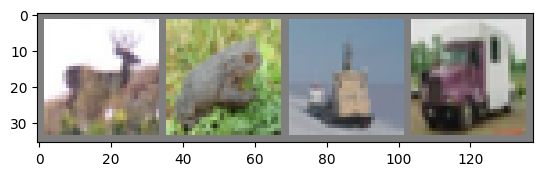

 deer  frog  ship truck


In [7]:
# 使用了torchvision.utils.make_grid函数，这个函数将多张图像拼接在一起，
# 形成一个网格状的大图像。然后用 imshow 函数将这个大图像显示出来。
imshow(torchvision.utils.make_grid(images))
# 打印出每张图像对应的标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    '''特征图尺寸的计算公式为：[(原图片尺寸 — 卷积核尺寸) / 步长 ] + 1'''
    def __init__(self):
        super(Net, self).__init__()
        # 第一个卷积层，输入通道数是3（因为CIFAR-10图像是彩色的，有红绿蓝三个通道），输出通道数是6，卷积核的大小是5x5。
        # 输入是32*32*3，计算（32-5）/ 1 + 1 = 28，那么通过conv1输出的结果是28*28*6
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 最大池化层，窗口大小和步长都是2
        # 输入是28*28*6，窗口2*2，计算28 / 2 = 14，那么通过max_pool1层输出结果是14*14*6
        self.pool = nn.MaxPool2d(2, 2)
        # 第二个卷积层，输入通道数是6（来自上一层的输出），输出通道数是16，卷积核的大小是5x5。
        # 输入是14*14*6，计算（14 - 5）/ 1 + 1 = 10，那么通过conv2输出的结果是10*10*16
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 第一个全连接层，输入节点数是 16 * 5 * 5，输出节点数是 120。
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 第二个全连接层，输入节点数是 120，输出节点数是 84。
        self.fc2 = nn.Linear(120, 84)
        # 第三个全连接层，输入节点数是84，输出节点数是10。输出节点数为10是因为CIFAR-10数据集有10个类别。
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''定义了网络的前向传播函数。在PyTorch中，只需要定义前向传播函数，
        后向传播函数会通过自动求导机制自动生成。这个函数的输入是一个batch的图像数据，
        输出是这个batch在每个类别上的得分。'''
        # 第一层卷积，然后通过激活函数ReLU，然后进行最大池化。
        # 32x32x3 --> 28x28x6 --> 14x14x6
        x = self.pool(F.relu(self.conv1(x)))
        # 第二层卷积，然后通过激活函数ReLU，然后进行最大池化。
        # 14x14x6 --> 10x10x16 --> 5x5x16
        x = self.pool(F.relu(self.conv2(x)))
        # 将二维的特征图(featue map)展平为一维，准备输入到全连接层。
        x = x.view(-1, 16 * 5 * 5)
        # 第一个全连接层，然后通过激活函数ReLU
        x = F.relu(self.fc1(x))
        # 第二个全连接层，然后通过激活函数ReLU
        x = F.relu(self.fc2(x))
        # 第三个全连接层，输出层
        x = self.fc3(x)
        # x是网络的输出，是一个大小为（batch_size, 10）的Tensor，每一行代表一个图像在每个类别上的得分。
        return x


In [9]:
net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 3. Define a Loss function and optimizer

In [10]:
import torch.optim as optim

# 定义了损失函数，这里使用的是交叉熵损失。对于分类问题，交叉熵损失是一种常用的损失函数。
# 这个函数将模型的输出（即在每个类别上的得分）和真实的标签作为输入，计算出一个标量值，代表了模型的损失。
# 模型的训练目标就是最小化这个损失。
criterion = nn.CrossEntropyLoss()

# 在每一步训练中，优化器都会根据损失函数的梯度来更新模型的参数，从而减小损失。
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 对训练数据集进行遍历，每一次循环，都会从trainloader中取出一个batch的数据。
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        # 获取一批训练数据和对应的标签，并将它们移到之前定义的设备（GPU或CPU）上。
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        # 在进行反向传播之前，需要将模型的所有参数的梯度清零。
        # 因为PyTorch的特性是累积梯度，如果不清零，梯度会被累积起来而不是被替换。
        optimizer.zero_grad()

        # forward + backward + optimize
        # 前向传播，将输入数据 inputs 传入模型，得到输出 outputs
        outputs = net(inputs)
        # 将模型的输出outputs和真实的标签labels作为输入，计算得到损失loss。
        loss = criterion(outputs, labels)
        # 反向传播，计算损失函数关于模型参数的梯度。
        loss.backward()
        # 优化器根据反向传播计算得到的梯度来更新模型的参数
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # 每2000个mini-batches打印一次平均损失
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            # 重置累积损失
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.198
[1,  4000] loss: 1.871
[1,  6000] loss: 1.691


In [ ]:
# 保存模型

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data

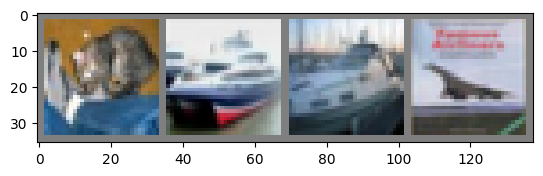

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# 从本地加载模型

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# 在测试集samples上推理

outputs = net(images)

In [ ]:
print(outputs)

tensor([[-0.7150, -2.0877,  1.1045,  3.1839, -0.8417,  1.9952, -0.1561, -0.4149,
         -1.1946, -1.9534],
        [ 5.5523,  7.7120, -3.4548, -5.1590, -4.2695, -5.5411, -4.7869, -3.8785,
          4.4290,  6.2757],
        [ 2.2058,  4.7520, -1.3847, -2.0772, -2.6066, -2.6668, -3.0878, -2.2175,
          1.8248,  3.7929],
        [ 3.5490,  1.1008, -0.5206, -2.2038, -0.4609, -3.8308, -3.6263, -2.3485,
          4.7082,  2.1138]], grad_fn=<AddmmBackward0>)


In [ ]:
# torch.max()函数找到模型输出中每个样本得分最高的类别的索引。
# torch.max()函数会返回两个Tensor，第一个Tensor是每行的最大值，第二个Tensor是最大值所在的索引（即预测的类别）。

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car  ship


In [ ]:
# 评估模型在整个测试集上的性能，它计算了模型的预测正确率（accuracy），即预测正确的样本数量占总样本数量的比例。

correct = 0 # 正确预测的数量
total = 0 # 总的样本数量
# 在评估模型的性能时，不需要更新模型的参数，也就不需要梯度。
with torch.no_grad():
    # 对测试数据集进行遍历
    for data in testloader:
        # 获取一批测试数据和对应的标签
        images, labels = data
        outputs = net(images)
        # 找到模型输出中每个样本得分最高的类别的索引，即模型的预测结果。
        _, predicted = torch.max(outputs.data, 1)
        # 更新总的样本数量，labels.size(0)返回这个batch的样本数量。
        total += labels.size(0)
        # 更新正确预测的数量
        # 首先(predicted==labels)返回一个布尔型的Tensor，表示预测结果和真实标签是否相等。
        # 然后，使用sum()函数计算这个batch中预测正确的样本数量，最后使用item()函数将这个数量转换为Python的标量。
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# 评估模型在每个类别上的预测性能，它分别计算了模型在每个类别上的预测正确的样本数量和总的样本数量。

class_correct = list(0. for i in range(10)) # 初始化每个类别的正确预测数量
class_total = list(0. for i in range(10)) # 总的样本数量
with torch.no_grad():
    # 每一次循环，都会取出一个batch的数据。
    for data in testloader:
        # 获取一批测试数据和对应的标签
        images, labels = data
        outputs = net(images)
        # 找到模型输出中每个样本得分最高的类别的索引，即模型的预测结果。
        _, predicted = torch.max(outputs, 1)
        # (predicted==labels)返回一个布尔型的Tensor，表示预测结果和真实标签是否相等。
        # 然后，使用squeeze()函数移除这个Tensor中长度为1的维度，使其变成一个一维Tensor。
        c = (predicted == labels).squeeze()
        # 对一个batch中的四个样本进行处理
        for i in range(4):
            # 获取第i个样本的真实标签
            label = labels[i]
            # 如果模型对第i个样本的预测结果是正确的，那么c[i]的值为1，否则为0。
            # 这里将c[i]的值累加到对应类别的正确预测数量中。
            class_correct[label] += c[i].item()
            # 更新对应类别的总的样本数量
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %
          (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 61 %
Accuracy of  bird : 34 %
Accuracy of   cat : 36 %
Accuracy of  deer : 53 %
Accuracy of   dog : 36 %
Accuracy of  frog : 74 %
Accuracy of horse : 66 %
Accuracy of  ship : 67 %
Accuracy of truck : 68 %


## 6. model inference with FastAPI

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from torchvision.transforms import transforms
import torch
import base64
import io
from PIL import Image

In [ ]:
app = FastAPI()

In [ ]:
# 加载本地的模型

model = Net()

model.load_state_dict(torch.load("cifar_net.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# 定义输入的数据模型

class Item(BaseModel):
    img_base64: str

In [ ]:
@app.post("/predict")
def predict(item: Item):
    # 对输入的base64图片进行解码和处理
    # 将base64编码的字符串解码回原始的二进制图像数据
    img = base64.b64decode(item.img_base64)
    # 将二进制图像数据转换为一个PIL的Image对象
    img = Image.open(io.BytesIO(img))
    # 定义transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # 图片预处理
    img = transform(img).unsqueeze(0).to(device)

    # 进行推理
    output = model(img)

    # 预测结果
    # pred = output.argmax(dim=1, keepdim=True)
    pred = torch.argmax(output, dim=1, keepdim=True)

    class_name = classes[pred]

    return {"prediction" : int(pred), "class_name": class_name}

## 7. test by requests

In [ ]:
import requests
import base64
import json
from PIL import Image

In [ ]:
# 打开图像

with open("test_images/img01.jpg", "rb") as f:
    img_bytes = f.read()

In [ ]:
# 转换为 base64 编码

img_b64 = base64.b64encode(img_bytes).decode("utf-8")


In [ ]:
# 方式-1 ： 启动服务后，发送 POST 请求

# response = requests.post("http://localhost:8000/predict", json= {"img_base64": img_b64})

In [ ]:
# 方式-2 ： 直接通过函数传参实现

item = Item(img_base64 = img_b64)


print(predict(item))

{'prediction': 9, 'class_name': 'truck'}


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
